# Solving the Problem

Now that we are armed with our ML models (way better than shotguns!) we can finally deal with our nasty little zombie problem.

Here's the plan:

* We show how to embed a ML model into an optimization model, using the EMLlib
* We build (and solve) an optimization model that includes the ML model

We will experiment with both the NN and the DT models. As an optimization techniques we will use Mixed Integer Linear Programming, via the well known IBM cplex solver.

The [EMLlib](https://github.com/emlopt/emllib) is a python module that implements EML techniques, including encoding, pre- and post-processing functions, and readers for popular ML frameworks. The project has just started and at the momement includes only the bare mininum needed to run this tutorial. More components will however be added in the coming months.

Currently, a version of the EMLlib is included in the tutorial code to make it self-contained (but that will change once a proper pip-based installer will be built).

First, we need to register the path to the EMLlib. This step will become unnnecessary once the proper pip-based installer will be available.

In [19]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import importlib

# Dynamically add the Empirical Model Learning folder to the python path
eml_path = '..'
if not eml_path in sys.path:
    sys.path.insert(1, eml_path)

Next, we (again) load some of our data (we will need it!):

In [20]:
# Load the data
data_fname = os.path.join('shared', 'za_processed.h5')
with pd.HDFStore(data_fname) as store:
    data = store['data']
    means_in = store['means_in']
    stds_in = store['stds_in']
    sim_in = store['sim_in']
    sim_out = store['sim_out']
    in_defaults = store['in_defaults']
    pop_size = store['meta']['pop_size']

This time we will need in particular the `in_defaults` series, which contains the default value for all our input parameters:

In [21]:
in_defaults

edge_ratio    0.004
inf_prob      0.700
act_rate      3.000
rec_rate      0.000
ds_rate       0.050
di_rate       0.000
dtype: float64

## Load and Convert Neural Network Models

We can now load our NN models, via [the API provided by keras]():

In [22]:
# Read the NN model
from keras.models import model_from_json

# Load the model architecture
net_prefixes = ['nn_reg_{}'.format(t) for t in sim_out]
knet = {}
def load_keras_nets(knet):
    # Load scalar output NNs
    for target, net_prefix in zip(sim_out, net_prefixes):
        net_fname = os.path.join('shared', '{}.json'.format(net_prefix))
        with open(net_fname) as fp:
            knet[target] = model_from_json(fp.read())

        # Load the model weights
        wgt_fname = os.path.join('shared', '{}.h5'.format(net_prefix))
        knet[target].load_weights(wgt_fname)

    # Load vector output NN (this one is available in a single version)
    net_fname = os.path.join('shared', 'nn_reg.json')
    with open(net_fname) as fp:
        knet['all'] = model_from_json(fp.read())

    # Load the model weights
    wgt_fname = os.path.join('shared', 'nn_reg.h5')
    knet['all'].load_weights(wgt_fname)
        
load_keras_nets(knet)

Now, the EMLlib allows us to convert the keras networks into an internal format with one line of code:

In [23]:
from eml.net import describe as ndescribe
from eml.net.reader import keras_reader

# Convert the Keras models in the EML format
net = {}
def convert_keras_net(knet, net):
    # Convert scalar-output NNs
    for target in sim_out:
        net[target] = keras_reader.read_keras_sequential(knet[target])
    
    # Convert vector-output NN
    net['all'] = keras_reader.read_keras_sequential(knet['all'])
        
convert_keras_net(knet, net)

## Handling ML Input Bounds

Many of the encodings employed by the EMLlib require **explicit bounds for the input variables of the ML model**.

In many practical cases, reasonable bound can be defined based on domain knowledge. Here, for simplicity we will treat the minimum/maximum value of each ML input in the dataset as its true lower/upper bound:

In [24]:
# Obtain basic input bounds from out dataset

# Compute minima and maxima
X_min, X_max = data[sim_in].min(), data[sim_in].max()
# Standardize
X_min = (X_min - means_in) / stds_in
X_max = (X_max - means_in) / stds_in

Embedding a Neural Network in a MILP model requires explicit bounds not only for the network input, but **also for all the hidden neurons**.

The EMLlib allows to perform the computation by:

1. Explicitly setting bounds on the neurons in the input layer
2. Automatically computing bounds for the hidden neurons via Interval Based Reasoning

The upper bound for the *activity* of the $i$-th neuron in the $k$-th layer is compued as:
$$
ub(y_{k,i}) = \theta_{k,i} + \sum_{(k-1, j) \text{ connected to } (k,i)} w_{k,i,j} \left\{\begin{aligned} ub(x_{k-1,j}) & \text{ if } w_{k,i,j} \geq 0 \\ lb(x_{k-1,j}) & \text{ otherwise}\end{aligned}\right.
$$

The upper bound for the neuron output is then computed as:
$$
ub(x_{k,i}= f(ub(y_{k,i}))
$$

The lower bound computation is analogous.

In [25]:
# Compute basic bounds
from eml.net import process as nprocess

def net_basic_bounds(net):
    for target in list(sim_out) + ['all']:
        # Reset existing bounds (just to ensure idempotence)
        net[target].reset_bounds()

        # Enforce basic input bounds
        in_layer = net[target].layer(0)
        for neuron, lb, ub in zip(in_layer.neurons(), X_min, X_max):
            neuron.update_lb(lb)
            neuron.update_ub(ub)

        # Compute bounds for the hidden neurons via Interval Based Reasoning
        nprocess.ibr_bounds(net[target])
        # Display the bounds
        print('=== TARGET: {}'.format(target))
        print(net[target])
        print()

net_basic_bounds(net)

=== TARGET: i_num
[input] (0, 0):[-1.414, 1.414] (0, 1):[-1.224, 1.224] (0, 2):[-1.224, 1.224] (0, 3):[-1.521, 1.183] (0, 4):[-1.224, 1.224] (0, 5):[-1.224, 1.224]
[dense,relu] (1, 0):[-2.443, 2.430]/[0.000, 2.430] (1, 1):[-2.492, 2.723]/[0.000, 2.723] (1, 2):[-2.776, 2.576]/[0.000, 2.576] (1, 3):[-2.133, 2.345]/[0.000, 2.345] (1, 4):[-1.746, 1.806]/[0.000, 1.806] (1, 5):[-1.762, 2.038]/[0.000, 2.038] (1, 6):[-1.861, 1.464]/[0.000, 1.464] (1, 7):[-2.548, 2.573]/[0.000, 2.573] (1, 8):[-1.108, 1.128]/[0.000, 1.128] (1, 9):[-1.529, 1.525]/[0.000, 1.525] (1, 10):[-0.721, 0.986]/[0.000, 0.986] (1, 11):[-1.360, 1.356]/[0.000, 1.356] (1, 12):[-1.807, 2.346]/[0.000, 2.346] (1, 13):[-3.316, 3.230]/[0.000, 3.230] (1, 14):[-1.671, 1.810]/[0.000, 1.810] (1, 15):[-2.610, 2.273]/[0.000, 2.273]
[dense,relu] (2, 0):[-2.543, 4.208]/[0.000, 4.208] (2, 1):[-3.211, 3.838]/[0.000, 3.838] (2, 2):[-4.208, 3.472]/[0.000, 3.472] (2, 3):[-6.134, 2.977]/[0.000, 2.977] (2, 4):[-3.733, 4.072]/[0.000, 4.072] (2, 5)

## Preparing for the Zombie Apocalypse (Problem Data)

It is now time to have a more detailed look **at the rest of the problem definition**, and namely:

* Which preparation mesures we can take
* How they affect the inputs of the ML model, i.e. the _features_ that describe our system

This information is all stored in the `measures.json` file in the `data` folder.

In [26]:
#
# Load problem data
#

import json

# Load the data about available measures
measure_fname = os.path.join('data', 'measures.json')
with open(measure_fname) as fp:
    mdata = json.load(fp)

# Separate the measure effect data from the combinations
effects = mdata['effects']
combinations = mdata['combinations']

print('=== The first two measures and their effects')
for effect in effects[:2]:
    print(effect)
print('')
print('=== All measure names')
print(', '.join(e['name'] for e in effects))
print('')
print('=== The first two combination bonuses')
for combo in combinations[:2]:
    print(combo)
print('')
print('=== All combinations')
print(', '.join('+'.join(c['deps']) for c in combinations))

=== The first two measures and their effects
{'name': 'training_hand2hand', 'act_rate': -0.3, 'ds_rate': -0.01, 'cost': 2}
{'name': 'training_melee', 'ds_rate': -0.005, 'di_rate': 0.02, 'cost': 3}

=== All measure names
training_hand2hand, training_melee, training_firearms, training_survival, training_stealth, training_medical, training_floormap, equipment_melee, equipment_pistols, equipment_shotguns, equipment_rifles, equipment_granades, equipment_taser, equipment_bodyarmor, equipment_helmet, equipment_supplies, equipment_medical, equipment_distraction, equipment_cure, building_sealed_doors, building_towers, building_manned_turrets, building_warehouses, building_medrooms, building_bunkers, policy_reduce_contact, policy_run, policy_hide, policy_fight, policy_protect, policy_cure

=== The first two combination bonuses
{'deps': ['training_melee', 'equipment_melee'], 'act_rate': -0.8}
{'deps': ['training_firearms', 'equipment_pistols'], 'act_rate': -0.7}

=== All combinations
training_mel

Each measure has a name, an effect (not necesarily beneficial) on one of more sytem features, and a cost.

Some measures can be combined to amplify their effect or counter their disadvantages. For example, equipping our staff with some kind of weapon and givinig them specific training is much more effective than the equipment or the training alone.

## Building the "Core Combinatorial Structure"

We can now start to build all the components in the optimization model that are not directly part of our network encoding. We sometimes refer to this collection to the **core combinatorial structure** of the problem, which  highlights alse the emphasis put by EML on *combinatorial* optimization problem.

We begin by building the decision variables that correspond to the (standardized/normalized) input/output of our Neural Networks:

In [27]:
#
# Build and solve a CPLEX model
#
from eml.backend import cplex_backend
import docplex.mp.model as cpx
from eml.net import embed as nembed

# Build a backend object
bkd = cplex_backend.CplexBackend()
# Build a docplex model
mdl = cpx.Model()

# Build input and output variables
X_vars = []
Y_vars = []
def build_inout_vars(bkd, mdl, X_vars, Y_vars):
    # Build one variable for each network input
    for in_name, lb, ub in zip(sim_in, X_min, X_max):
        X_vars.append(mdl.continuous_var(lb=lb, ub=ub, name=in_name))

    # Build one variable for each network output
    for out_name in sim_out:
        # NOTE use slightly larger bounds (to account for approximation errors)
        Y_vars.append(mdl.continuous_var(lb=-1, ub=2, name=out_name))

build_inout_vars(bkd, mdl, X_vars, Y_vars)

print(cplex_backend.model_to_string(mdl))

minimize: 0
subject to:
with vars:
	-1.413777 <= edge_ratio <= 1.413777
	-1.224367 <= inf_prob <= 1.224367
	-1.224367 <= act_rate <= 1.224367
	-1.520808 <= rec_rate <= 1.182851
	-1.224367 <= ds_rate <= 1.224367
	-1.224367 <= di_rate <= 1.224367
	-1.000000 <= i_num <= 2.000000
	-1.000000 <= survivors <= 2.000000



Our model is designed using the [docplex]() modeling interface.

The same technology is also employed by the cplex backend of the EMLlib, which we will need to encode the NNs.

For sake of clarity it is usuful to introduce a "natural scale" (i.e non standardized/normalize) version of the NN input and output.

In principle, these will need to be connected to the actual NN input/output varibles via simple linear constraints that correspond to the standardization/normalization. This is actually true only for the *output* variables:

In [28]:
#
# Build and solve a CPLEX model
#

from eml.backend import cplex_backend
import docplex.mp.model as cpx
from eml.net import embed as nembed

# Build a backend object
bkd = cplex_backend.CplexBackend()
# Build a docplex model
mdl = cpx.Model()
X_vars = []
Y_vars = []

# Build input and output variables
build_inout_vars(bkd, mdl, X_vars, Y_vars)

# Build a natural scale version of each output variable
from eml import util
importlib.reload(util)
Y_nat = []
def build_nat_out(bkd, mdl, Y_nat):
    for i, out_name in enumerate(sim_out):
        # Build the natural scale variable
        lb = Y_vars[i].lb * pop_size
        ub = Y_vars[i].ub * pop_size
        ynat = mdl.continuous_var(lb=lb, ub=ub, name=out_name+'_nat')
        Y_nat.append(ynat)

        # Add the standardization constraints
        mdl.add_constraint(Y_nat[i] == Y_vars[i] * pop_size)

build_nat_out(bkd, mdl, Y_nat)

print(cplex_backend.model_to_string(mdl))

minimize: 0
subject to:
	i_num_nat == 500i_num
	survivors_nat == 500survivors
with vars:
	-1.413777 <= edge_ratio <= 1.413777
	-1.224367 <= inf_prob <= 1.224367
	-1.224367 <= act_rate <= 1.224367
	-1.520808 <= rec_rate <= 1.182851
	-1.224367 <= ds_rate <= 1.224367
	-1.224367 <= di_rate <= 1.224367
	-1.000000 <= i_num <= 2.000000
	-1.000000 <= survivors <= 2.000000
	-500.000000 <= i_num_nat <= 1000.000000
	-500.000000 <= survivors_nat <= 1000.000000



The input variables are slighly trickier to handle, because it may happen that stacking effects of the measures we chose end up pushing one standardized/normalized variable out of its bounds.

Whenever this happens, a MILP solver would consider such solution infeasible. In practice, it is more reasonable to think that in such a case the variable reaches a plateau.

In other words, the natural scale input variables are connected to their standarized/normalized counterparts both by standardization/normalization constraints *and by capping constraints*.

These can be modeled in a compact form via a piecewise linear function with this shape:

([<matplotlib.axis.YTick at 0x1204ef518>,
 <a list of 2 Text yticklabel objects>)

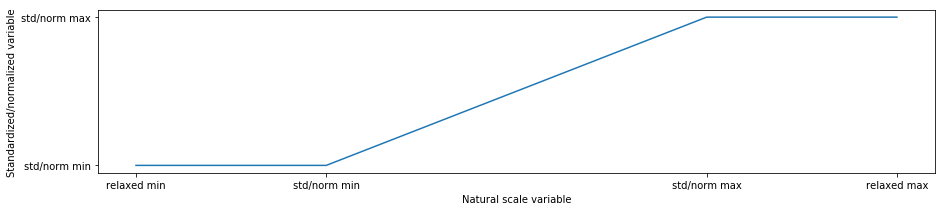

In [29]:
plt.figure(figsize=(15, 3))
plt.plot([-2, -1, 1, 2], [-1, -1, 1, 1])
plt.xlabel('Natural scale variable')
plt.ylabel('Standardized/normalized variable')
plt.xticks([-2, -1, 1, 2], ['relaxed min', 'std/norm min', 'std/norm max', 'relaxed max'])
plt.yticks([-1, 1], ['std/norm min', 'std/norm max'])

The EMLlib provides an easy way to encode piecewise linear functions. This is actually just a coincidence, becasue this type of function plays a role in some encodings.

The method is the `encode_pwl` function from the `util` module. The function requires to specify:

* The backend object to be used for the encoding
* The model where the function should be inserted
* The variables that should be connected via a piecewise linear function
* A list of nodes, i.e. the vector of x and y coordinates in the plot above

In [30]:
#
# Build and solve a CPLEX model
#

from eml.backend import cplex_backend
import docplex.mp.model as cpx
from eml.net import embed as nembed

# Build a backend object
bkd = cplex_backend.CplexBackend()
# Build a docplex model
mdl = cpx.Model()
X_vars = []
Y_vars = []
Y_nat = []
X_nat = []

# Build input and output variables
build_inout_vars(bkd, mdl, X_vars, Y_vars)
# Build a natural scale version of each output variable
build_nat_out(bkd, mdl, Y_nat)

# Build a natural scale version of each input variable
X_nat = []
def build_nat_in(bkd, mdl, X_nat):
    for i, (in_name, lb, ub) in enumerate(zip(sim_in, X_min, X_max)):
        # Build the natural scale variable
        mean, std = means_in[in_name], stds_in[in_name]
        lb_nat = lb * std + mean
        ub_nat = ub * std + mean
        span = ub_nat - lb_nat
        xnat = mdl.continuous_var(lb=lb_nat-span, ub=ub_nat+span,
                                  name=in_name+'_nat')
        X_nat.append(xnat)

        # Add the capping & standardization constraints
        nat_nodes = [lb_nat-span, lb_nat, ub_nat, ub_nat+span]
        std_nodes = [lb, lb, ub, ub]
        util.encode_pwl(bkd, mdl, xvars=[X_nat[i], X_vars[i]],
                        nodes=[nat_nodes, std_nodes],
                       name=in_name)

build_nat_in(bkd, mdl, X_nat)

We can then build a binary variable for each measure, and one for each combination of measures that is associated to an extra effect:

In [31]:
#
# Build and solve a CPLEX model
#

from eml.backend import cplex_backend
import docplex.mp.model as cpx
from eml.net import embed as nembed
from eml import util

# Build a backend object
bkd = cplex_backend.CplexBackend()
# Build a docplex model
mdl = cpx.Model()
X_vars = []
Y_vars = []
Y_nat = []
X_nat = []

# Build input and output variables
build_inout_vars(bkd, mdl, X_vars, Y_vars)
# Build a natural scale version of each output variable
build_nat_out(bkd, mdl, Y_nat)
# Build a natural scale version of each input variable
build_nat_in(bkd, mdl, X_nat)

# Build variables for the measures and their combinations
M_vars = []
C_vars = []
M_map = {}
def build_measure_vars(bkd, mdl, M_vars, C_vars, M_map):
    # Build one binary variable per measure
    for i, effect in enumerate(effects):
        mvar = mdl.binary_var(name=effect['name'])
        M_vars.append(mvar)
        M_map[effect['name']] = i

    # Build one binary variable per combination
    for i, combo in enumerate(combinations):
        cvar = mdl.binary_var(name='-'.join(combo['deps']))
        C_vars.append(cvar)

build_measure_vars(bkd, mdl, M_vars, C_vars, M_map)

The combination variables can be set to 1 only if all the basic measures they depend have been chosen:

In [32]:
#
# Build and solve a CPLEX model
#

from eml.backend import cplex_backend
import docplex.mp.model as cpx
from eml.net import embed as nembed
from eml import util

# Build a backend object
bkd = cplex_backend.CplexBackend()
# Build a docplex model
mdl = cpx.Model()
X_vars = []
Y_vars = []
Y_nat = []
X_nat = []
M_vars = []
C_vars = []
M_map = {}

# Build input and output variables
build_inout_vars(bkd, mdl, X_vars, Y_vars)
# Build a natural scale version of each output variable
build_nat_out(bkd, mdl, Y_nat)
# Build a natural scale version of each input variable
build_nat_in(bkd, mdl, X_nat)
# Build variables for the measures and their combinations
build_measure_vars(bkd, mdl, M_vars, C_vars, M_map)

# Build dependency constraints
def build_dependencies(bkd, mdl):
    for i, combo in enumerate(combinations):
        ndeps = len(combo['deps'])
        mvars = [M_vars[M_map[name]] for name in combo['deps']]
        mdl.add_constraint(ndeps * C_vars[i] <= sum(mvars))

build_dependencies(bkd, mdl)

Then, we can specify that each NN input (i.e. feature that descibe the system) is given by its defalt value, modified by all the measures that can affect it and have been selected, and by all applicable combinations. In oter words:
$$
feat_i = default(feat_i) + \sum_{j \in \text{ measures}} eff_{i,j} x_j + \sum_{j \in \text{ combinations}} eff_{i,j} y_j
$$

Where $x$ refers here to the measure variables and $y$ to the combination variables:

In [33]:
#
# Build and solve a CPLEX model
#

from eml.backend import cplex_backend
import docplex.mp.model as cpx
from eml.net import embed as nembed
from eml import util

# Build a backend object
bkd = cplex_backend.CplexBackend()
# Build a docplex model
mdl = cpx.Model()
X_vars = []
Y_vars = []
Y_nat = []
X_nat = []
M_vars = []
C_vars = []
M_map = {}

# Build input and output variables
build_inout_vars(bkd, mdl, X_vars, Y_vars)
# Build a natural scale version of each output variable
build_nat_out(bkd, mdl, Y_nat)
# Build a natural scale version of each input variable
build_nat_in(bkd, mdl, X_nat)
# Build variables for the measures and their combinations
build_measure_vars(bkd, mdl, M_vars, C_vars, M_map)
# Build dependency constraints
build_dependencies(bkd, mdl)

# Connect effects and combinations to the natural-scale network inputs
def build_measure_effect_csts(bkd, mdl):
    for i, in_name in enumerate(sim_in):
        # Effects to input
        coefs, evars = [], []
        for j, effect in enumerate(effects):
            if in_name in effect:
                coefs.append(effect[in_name])
                evars.append(M_vars[j])
        # Combinations to input
        for j, combo in enumerate(combinations):
            if in_name in combo:
                coefs.append(combo[in_name])
                evars.append(C_vars[j])
        # Build the connection constraint
        mdl.add_constraint(X_nat[i] == in_defaults[i] + mdl.scal_prod(evars, coefs))

build_measure_effect_csts(bkd, mdl)

We ca adopt a similar approach to compute the overall cost:

In [34]:
#
# Build and solve a CPLEX model
#

from eml.backend import cplex_backend
import docplex.mp.model as cpx
from eml.net import embed as nembed
from eml import util

# Build a backend object
bkd = cplex_backend.CplexBackend()
# Build a docplex model
mdl = cpx.Model()
X_vars = []
Y_vars = []
Y_nat = []
X_nat = []
M_vars = []
C_vars = []
M_map = {}

# Build input and output variables
build_inout_vars(bkd, mdl, X_vars, Y_vars)
# Build a natural scale version of each output variable
build_nat_out(bkd, mdl, Y_nat)
# Build a natural scale version of each input variable
build_nat_in(bkd, mdl, X_nat)
# Build variables for the measures and their combinations
build_measure_vars(bkd, mdl, M_vars, C_vars, M_map)
# Build dependency constraints
build_dependencies(bkd, mdl)
# Connect effects and combinations to the natural-scale network inputs
build_measure_effect_csts(bkd, mdl)

# Build and constraint the cost variable
cost_var = mdl.continuous_var(name='cost')
def build_cost_structure(bkd, mdl, cost_var):
    # Measures to cost
    coefs, evars = [], []
    for i, effect in enumerate(effects):
        coefs.append(effect['cost'])
        evars.append(M_vars[i])
    mdl.add_constraint(cost_var == mdl.scal_prod(evars, coefs))

build_cost_structure(bkd, mdl, cost_var)

## Embedding our NN Models

We can embed our well-earned MM models! Using the EMLlib, this is in fact quite easy. In detail:

* The `encode` function in the `net.embed` modules does all the work
* We just need to pass a backend, the network to be encoded, the target model object, and the input/output variables

In [35]:
#
# Build and solve a CPLEX model
#

from eml.backend import cplex_backend
import docplex.mp.model as cpx
from eml.net import embed as nembed
from eml import util

# Build a backend object
bkd = cplex_backend.CplexBackend()
# Build a docplex model
mdl = cpx.Model()
X_vars = []
Y_vars = []
Y_nat = []
X_nat = []
M_vars = []
C_vars = []
M_map = {}
cost_var = mdl.continuous_var(name='cost')

# Build input and output variables
build_inout_vars(bkd, mdl, X_vars, Y_vars)
# Build a natural scale version of each output variable
build_nat_out(bkd, mdl, Y_nat)
# Build a natural scale version of each input variable
build_nat_in(bkd, mdl, X_nat)
# Build variables for the measures and their combinations
build_measure_vars(bkd, mdl, M_vars, C_vars, M_map)
# Build dependency constraints
build_dependencies(bkd, mdl)
# Connect effects and combinations to the natural-scale network inputs
build_measure_effect_csts(bkd, mdl)
# Build and constraint the cost variable
build_cost_structure(bkd, mdl, cost_var)

# Encode the network
def build_network_encoding(bkd, mdl, mode='scalar'):
    if mode == 'scalar':
        for i, target in enumerate(sim_out):
            nembed.encode(bkd, net[target], mdl, X_vars, Y_vars[i], target)
    elif mode == 'vector':
        nembed.encode(bkd, net['all'], mdl, X_vars, Y_vars, 'all')
        
build_network_encoding(bkd, mdl)

## Obtaining a Solution

Now we just need to specify our "goal" constraints and the objective function. In particular we want:

* A total cost below a given threshold
* A very small final number of zombies
* The largest possible number of survivors

In [39]:
#
# Build and solve a CPLEX model
#

from eml.backend import cplex_backend
import docplex.mp.model as cpx
from eml.net import embed as nembed
from eml import util

# Build a backend object
bkd = cplex_backend.CplexBackend()
# Build a docplex model
mdl = cpx.Model()
X_vars = []
Y_vars = []
Y_nat = []
X_nat = []
M_vars = []
C_vars = []
M_map = {}
cost_var = mdl.continuous_var(name='cost')

# Build input and output variables
build_inout_vars(bkd, mdl, X_vars, Y_vars)
# Build a natural scale version of each output variable
build_nat_out(bkd, mdl, Y_nat)
# Build a natural scale version of each input variable
build_nat_in(bkd, mdl, X_nat)
# Build variables for the measures and their combinations
build_measure_vars(bkd, mdl, M_vars, C_vars, M_map)
# Build dependency constraints
build_dependencies(bkd, mdl)
# Connect effects and combinations to the natural-scale network inputs
build_measure_effect_csts(bkd, mdl)
# Build and constraint the cost variable
build_cost_structure(bkd, mdl, cost_var)
# Encode the network
build_network_encoding(bkd, mdl, 'vector')

# Budget
mdl.add_constraint(cost_var <= 50)
# Zombies
mdl.add_constraint(Y_nat[0] <= 20)
# Survivors
mdl.set_objective('max', Y_nat[0])

# Solve
mdl.set_time_limit(30)
print('=== Starting the solution process')
sol = mdl.solve()

if sol is None:
    print('No solution found')
else:
    print('=== SOLUTION DATA')
    print('Solution time: {:.2f} (sec)'.format(mdl.solve_details.time))
    print('Solver status: {}'.format(sol.solve_details.status))
    print('Survivors: {}'.format(sol[Y_nat[1]]))
    print('Zombies: {}'.format(sol[Y_nat[0]]))
    print('Cost: {}'.format(sol[cost_var]))
    print('Chosen measures:')
    for x, effect in zip(M_vars, effects):
        if sol[x] > 0:
            print('* {}'.format(effect['name']))
    print('Applicable bonuses:')
    for x, combo in zip(C_vars, combinations):
        if sol[x] > 0:
            print('* {}'.format(' + '.join(combo['deps'])))
    cstring = 'c({})'.format(', '.join('{:.3f}'.format(max(0, sol[x])) for x in X_nat))
    print('Evaluation string: {}'.format(cstring))

=== Starting the solution process
=== SOLUTION DATA
Solution time: 18.94 (sec)
Solver status: integer optimal solution
Survivors: 472.7338763503302
Zombies: 19.974291415756305
Cost: 50.0
Chosen measures:
* training_hand2hand
* training_firearms
* training_survival
* training_stealth
* training_floormap
* equipment_pistols
* equipment_bodyarmor
* equipment_helmet
* equipment_distraction
* building_sealed_doors
* building_towers
* building_bunkers
* policy_reduce_contact
* policy_hide
Applicable bonuses:
* training_firearms + equipment_pistols
* training_stealth + policy_hide
Evaluation string: c(0.002, 0.500, 1.200, 0.000, 0.000, 0.070)


## Efficiency Issues

It turns out that solving the problem is as easy as it originally looked!

This is largely due to the complexity of handling the NN encoding, even if the network is not by itself large.

It turns out that NNs have a particularly nasty combination of characteristics from the perspective of a MILP encoding:

* Each fully connected layer leads to a dense block in the coefficient matrix, something that most MILP solver really *don't* like
* Linearizing the ReLU activation functions requires using a big-M, whose value depends on the bound computed in our pre-processing step. The weaker the bounds, the weaker the encoding. Since the bound quality decreases with the network depth, deeper networks are hard to deal with.

Is there something we can do? Yes, definitely. We can:

1. Use a simpler network!
   * If we do, we may loose some accuracy, but hopefully not too much: our solution will be approximated in any case.
   * In general, **there is always a trade-off between the complexity and accuracy of the ML model and how efficiently it can be managed by the solver**
2. We can **compute better bounds**!
   * A nice approach consists in repeatedly solving a MILP model that consists in just the network encoding
   * Every time, we change the objective function so that it matches either the lower or the upper bound of a neuron
   * This process can be performed in a forwad fashion, by exploiting the feed-forward nature of the network
   
The approach is not particularly complex, and it is well described in [this paper by Matteo Fischetti et al.](https://arxiv.org/abs/1712.06174).

In the EMLlib, it is implemented in the `fwd_bound_tightening` function from the `net.process` module:

In [42]:
#
# Preprocessing: bound tightening
#
from eml.backend import cplex_backend

# Build a backend object
bkd = cplex_backend.CplexBackend()

# Run forward bound tightening
timelimit = 10
def net_bound_tightening(net, timelimit):
    for target in list(sim_out) + ['all']:
        nprocess.fwd_bound_tighthening(bkd, net=net[target],
                                      timelimit=timelimit)
        # Display the bounds
        print('=== TARGET: {}'.format(target))
        print(net[target])
        print()

net_bound_tightening(net, timelimit)

=== TARGET: i_num
[input] (0, 0):[-1.414, 1.414] (0, 1):[-1.224, 1.224] (0, 2):[-1.224, 1.224] (0, 3):[-1.521, 1.183] (0, 4):[-1.224, 1.224] (0, 5):[-1.224, 1.224]
[dense,relu] (1, 0):[-2.443, 2.430]/[0.000, 2.430] (1, 1):[-2.492, 2.723]/[0.000, 2.723] (1, 2):[-2.776, 2.576]/[0.000, 2.576] (1, 3):[-2.133, 2.345]/[0.000, 2.345] (1, 4):[-1.746, 1.806]/[0.000, 1.806] (1, 5):[-1.762, 2.038]/[0.000, 2.038] (1, 6):[-1.861, 1.464]/[0.000, 1.464] (1, 7):[-2.548, 2.573]/[0.000, 2.573] (1, 8):[-1.108, 1.128]/[0.000, 1.128] (1, 9):[-1.529, 1.525]/[0.000, 1.525] (1, 10):[-0.721, 0.986]/[0.000, 0.986] (1, 11):[-1.360, 1.356]/[0.000, 1.356] (1, 12):[-1.807, 2.346]/[0.000, 2.346] (1, 13):[-3.316, 3.230]/[0.000, 3.230] (1, 14):[-1.671, 1.810]/[0.000, 1.810] (1, 15):[-2.610, 2.273]/[0.000, 2.273]
[dense,relu] (2, 0):[-0.732, 1.547]/[0.000, 1.547] (2, 1):[-1.059, 1.393]/[0.000, 1.393] (2, 2):[-1.781, 0.821]/[0.000, 0.821] (2, 3):[-2.472, 0.601]/[0.000, 0.601] (2, 4):[-0.737, 1.548]/[0.000, 1.548] (2, 5)

The new bounds are much tighter than the old ones!

It takes some time to generate them, but **we need to perform this step only once per model**. Then, we can use the model with tighter bound to define as many optimization problems we wish.

We can now try to solve the problem again:

In [43]:
#
# Build and solve a CPLEX model
#

from eml.backend import cplex_backend
import docplex.mp.model as cpx
from eml.net import embed as nembed
from eml import util

# Build a backend object
bkd = cplex_backend.CplexBackend()
# Build a docplex model
mdl = cpx.Model()
X_vars = []
Y_vars = []
Y_nat = []
X_nat = []
M_vars = []
C_vars = []
M_map = {}
cost_var = mdl.continuous_var(name='cost')

# Build input and output variables
build_inout_vars(bkd, mdl, X_vars, Y_vars)
# Build a natural scale version of each output variable
build_nat_out(bkd, mdl, Y_nat)
# Build a natural scale version of each input variable
build_nat_in(bkd, mdl, X_nat)
# Build variables for the measures and their combinations
build_measure_vars(bkd, mdl, M_vars, C_vars, M_map)
# Build dependency constraints
build_dependencies(bkd, mdl)
# Connect effects and combinations to the natural-scale network inputs
build_measure_effect_csts(bkd, mdl)
# Build and constraint the cost variable
build_cost_structure(bkd, mdl, cost_var)
# Encode the network
build_network_encoding(bkd, mdl, 'vector')

# Budget
mdl.add_constraint(cost_var <= 50)
# Zombies
mdl.add_constraint(Y_nat[0] <= 20)
# Survivors
mdl.set_objective('max', Y_nat[0])

# Solve
mdl.set_time_limit(30)
print('=== Starting the solution process')
sol = mdl.solve()

if sol is None:
    print('No solution found')
else:
    print('=== SOLUTION DATA')
    print('Solution time: {:.2f} (sec)'.format(mdl.solve_details.time))
    print('Solver status: {}'.format(sol.solve_details.status))
    print('Survivors: {}'.format(sol[Y_nat[1]]))
    print('Zombies: {}'.format(sol[Y_nat[0]]))
    print('Cost: {}'.format(sol[cost_var]))
    print('Chosen measures:')
    for x, effect in zip(M_vars, effects):
        if sol[x] > 0:
            print('* {}'.format(effect['name']))
    print('Applicable bonuses:')
    for x, combo in zip(C_vars, combinations):
        if sol[x] > 0:
            print('* {}'.format(' + '.join(combo['deps'])))
    cstring = 'c({})'.format(', '.join('{:.3f}'.format(max(0, sol[x])) for x in X_nat))
    print('Evaluation string: {}'.format(cstring))

=== Starting the solution process
=== SOLUTION DATA
Solution time: 18.45 (sec)
Solver status: integer optimal solution
Survivors: 472.7338585878269
Zombies: 19.974291836035743
Cost: 49.0
Chosen measures:
* training_firearms
* training_survival
* training_stealth
* training_floormap
* equipment_pistols
* equipment_bodyarmor
* equipment_helmet
* equipment_distraction
* building_sealed_doors
* building_towers
* building_bunkers
* policy_reduce_contact
* policy_run
* policy_hide
Applicable bonuses:
* training_firearms + equipment_pistols
* training_stealth + policy_hide
Evaluation string: c(0.002, 0.500, 1.200, 0.000, 0.000, 0.070)


It is time to test the solution we have just obtained: copy the "evaluation string" in the the output above nad